Import dependencies

In [1]:
import sys

sys.path.append("..")

import numpy as np
from PIL import Image
from tqdm import tqdm
import cv2
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import matplotlib.pyplot as plt

import deeptrack as dt
from utils import UNet

cpu


/Users/xbacss/Documents/GitHub/DeepTrack2/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/Users/xbacss/Documents/GitHub/DeepTrack2/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
2023-09-11 18:21:14.108887: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Here we import all the code we have written before in the simulation noteboook.

In [2]:
# Define the final image size
IMAGE_SIZE = 256

# Define the optical system
optics = dt.Fluorescence(
    wavelength=500e-9,
    NA=1.2,
    resolution=1e-6,
    magnification=12,
    refractive_index_medium=1.33,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
)

# Define point particles that represent plankton species, Dunaliella tertiolecta
point_particles = dt.Sphere(
    position=lambda: np.random.uniform(0, IMAGE_SIZE, 2),
    radius=lambda: np.random.uniform(0.2e-6, 0.4e-6),
    intensity=lambda: np.random.uniform(1, 1.5),
    z=lambda: np.random.uniform(-5, 5),
)

# Define inner spheres that represent plankton species, Noctiluca scintillans
inner_spheres = dt.Sphere(
    position=lambda: np.random.uniform(0, IMAGE_SIZE, 2),
    radius=lambda: np.random.uniform(2e-6, 5e-6),
    intensity=lambda: -1 * np.random.uniform(0.8, 1.2),
)

# Define outer spheres that represent plankton species, Noctiluca scintillans
outer_spheres = dt.Sphere(
    position=inner_spheres.position,
    radius=inner_spheres.radius * 1.1,
    intensity=inner_spheres.intensity * -1,
)

# Combine the inner and outer spheres to create a single plankton species
combined_spheres = inner_spheres >> outer_spheres

# Define the number of Dunaliealla and Noctiluca in the image
point_particles_in_image = lambda: np.random.randint(20, 30)
spheres_in_image = lambda: np.random.randint(1, 3)

# Define the transformations applied to the point particles (Dunaliella tertiolecta)
point_cells = (
    (point_particles ^ point_particles_in_image)
    >> dt.Pad(px=(5, 5, 5, 5))
    >> dt.ElasticTransformation(alpha=50, sigma=8, order=1)
    >> dt.CropTight()
    >> dt.Poisson(snr=3)
    # You can add more transformations here
)

# Define the transformations applied to the spheres (Noctiluca scintillans)
spherical_cells = (
    (combined_spheres ^ spheres_in_image)
    >> dt.Pad(px=(5, 5, 5, 5))
    >> dt.ElasticTransformation(alpha=50, sigma=8, order=1)
    >> dt.CropTight()
    >> dt.Poisson(snr=3)
    # You can add more transformations here
)

# Normalize the images: For noise approriate level of noise in the next step
normalization = dt.NormalizeMinMax(
    min=lambda: np.random.rand() * 0.4,
    max=lambda min: min + 0.1 + np.random.rand() * 0.5,
)

# Add Poisson noise to the image
noise = dt.Poisson(snr=lambda: np.random.uniform(30, 40), background=normalization.min)

# Define the final sample
sample = optics(point_cells & spherical_cells) >> normalization >> noise

# Write a function to extract massk for Noctiluca scintillans
def transf():
    def inner(scatter_mask):

        mask = scatter_mask.sum(-1) != 0
        output = np.zeros((*scatter_mask.shape[:2], 1))

        output[mask] = 1

        return output

    return inner

# Write a function to extract massk for Dunaliella tertiolecta
def transf2(circle_radius=3):
    def inner(image):
        X, Y = np.mgrid[: 2 * circle_radius, : 2 * circle_radius]
        CIRCLE = (X - circle_radius + 0.5) ** 2 + (
            Y - circle_radius + 0.5
        ) ** 2 <= circle_radius**2
        CIRCLE = CIRCLE[..., None]
        return CIRCLE

    return inner

# Apply the functions to the sample
masks1 = spherical_cells >> dt.SampleToMasks(
    transf, output_region=optics.output_region, merge_method="or", number_of_masks=1
)

masks2 = point_cells >> dt.SampleToMasks(
    transf2, output_region=optics.output_region, merge_method="or", number_of_masks=1
)

# Combine the sample and the masks
image_and_labels = sample & masks1 & masks2

def generate_images():
    return image_and_labels

Create helper functions to transform masks in a proper format for training

In [3]:
def transform_masks(m1, m2):
    combined_mask = m1 + m2 * 2
    combined_mask[combined_mask == 3] = 1  # When overlapping, only keep the first mask
    return combined_mask

### Generate training data
You can control whether you want to train a new model or load a pre-trained model by setting the parameter `TRAIN` to `True` or `False` respectively.

By default, we will load a pre-trained model.

In [6]:
# Set TRAIN to True to generate new data for trianing the network
TRAIN = False

In [7]:
if TRAIN:

    DATA_LENGTH = 1024

    train_images = []
    train_labels = []
    for i in tqdm(range(DATA_LENGTH), desc="Generating training data"):
        img, mask1, mask2 = generate_images().update()()
        img = np.array(img)
        mask1 = np.array(mask1)
        mask2 = np.array(mask2)
        train_images.append(img)
        train_labels.append(transform_masks(mask1, mask2))  # already summed
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)

In [8]:
if TRAIN:

    VAL_DATA_LENGTH = 256

    val_images = []
    val_labels = []
    for i in tqdm(range(VAL_DATA_LENGTH), desc="Generating validation data"):
        img, mask1, mask2 = generate_images().update()()
        img = np.array(img)
        mask1 = np.array(mask1)
        mask2 = np.array(mask2)
        val_images.append(img)
        val_labels.append(transform_masks(mask1, mask2))  # already summed
    val_images = np.array(val_images)
    val_labels = np.array(val_labels)

Prepare the dataloaders


In [9]:
if TRAIN:

    # Prepare training data and loaders
    training_set = torch.utils.data.TensorDataset(
        torch.from_numpy(train_images).float().permute(0, 3, 1, 2),
        torch.from_numpy(train_labels).float().permute(0, 3, 1, 2),
    )
    trainloader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True)

    # Create validation data and loaders
    validation_set = torch.utils.data.TensorDataset(
        torch.from_numpy(val_images).float().permute(0, 3, 1, 2),
        torch.from_numpy(val_labels).float().permute(0, 3, 1, 2),
    )
    validationloader = torch.utils.data.DataLoader(
        validation_set, batch_size=32, shuffle=True
    )

Define U-Net model

In [10]:
model = UNet(
    input_shape=(1, 1, 256, 256),
    number_of_output_channels=3,  # 2 for binary segmentation and 3 for multiclass segmentation
    conv_layer_dimensions=(8, 16, 32, 64, 128, 256),  # smaller UNet (faster training)
)

Define loss function and optimizer

In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, amsgrad=True)

### Train the network
In the following code, we will train the U-Net model for 200 epochs. Set the `TRAIN` parameter to `True` in the above cells (generating data) to train the model, and to `False` to load the pre-trained model. By default, the pre-trained model is loaded.

In [12]:
if TRAIN:
    epochs = 200

    # Save the loss history
    train_loss = []
    val_loss = []

    for epoch in range(epochs):

        num_batches = len(trainloader)

        print("\n")

        print(f"Epoch {epoch+1}/{epochs}")
        print("-" * 10)

        running_train_loss = 0.0

        # Set the model to training mode
        model.train(True)

        # looping over batches
        for batch_idx, data in enumerate(trainloader, start=0):

            # get the inputs and labels for each batch
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            # loss = criterion(outputs, labels)  # For BCEWithLogitsLoss
            loss = criterion(outputs, torch.sum(labels, dim=1).long())
            # loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()


            if batch_idx % 10 == 0:
                print(
                    f"Batch {batch_idx}/{num_batches} loss: {loss.item():.4f}"
                )

            # Save the loss for this batch
            running_train_loss += loss.item()

        # Save the loss for this epoch
        train_loss.append(running_train_loss / num_batches)

        # Print the loss for this epoch
        print("-" * 10)
        print(
            f"Epoch {epoch+1}/{epochs} : Training loss: {train_loss[-1]:.4f}"
        )

        # Set the model to evaluation mode
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # loss = criterion(outputs, labels)  # For BCEWithLogitsLoss
            loss = criterion(
                outputs, torch.sum(labels, dim=1).long()
            )  # For CrossEntropyLoss

            running_val_loss += loss.item()

        # Save the loss for this epoch
        val_loss.append(running_val_loss / num_batches)

        # Print the loss for this epoch
        print(f"Epoch {epoch+1}/{epochs} : Validation loss: {val_loss[-1]:.4f}")

    # Save the model
    torch.save(model.state_dict(), "unet_model_just_trained.pth")

    # Plot the loss history
    plt.plot(train_loss, label="Training loss")
    plt.plot(val_loss, label="Validation loss")
    plt.legend()
    plt.show()

else:
    print("Loading pre-trained model")
    model.load_state_dict(
        torch.load(
            "../data/pre-trained-models/UNet-noctiluca-dunaliella.pth",
            map_location=torch.device(device),
        )
    )

Loading pre-trained model


### Test the network on experimental image
Define the helper functions as we defined in the simulation notebook

In [32]:
def center_crop(image, center, window_size=20):
    """
    Crop an image around a center point.
    """
    x_center, y_center = center
    half_window = window_size // 2

    x_min = int(x_center - half_window)
    x_max = int(x_center + half_window)
    y_min = int(y_center - half_window)
    y_max = int(y_center + half_window)

    cropped_image = image[y_min:y_max, x_min:x_max]
    return cropped_image

In [33]:
original_image = np.array(Image.open("../data/noctiluca-data/noctiluca_exp_image.jpg"))
exp_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

pos = [750, 450]

# Downsample the image using deeptrack average pooling
downsample = 2
exp_img = dt.Value(exp_image) >> dt.AveragePooling(ksize=(downsample, downsample))
original_image = dt.Value(original_image) >> dt.AveragePooling(ksize=(downsample, downsample, 1))

# Update the image
exp_img = exp_img.update()()
original_image = original_image.update()()

# Center crop the image at give pos
cropped_image = center_crop(
    exp_img, [pos[0] // downsample, pos[1] // downsample], window_size=256
)
original_image = center_crop(
    original_image, [pos[0] // downsample, pos[1] // downsample], window_size=256
)


Apply the trained model to the experimental image to obtain the segmentation masks of two different species, 

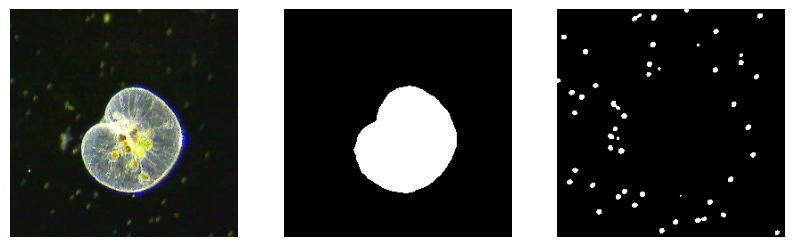

In [35]:
input = cropped_image[None, None, :, :]
# input = exp_image[None, None, :, :]
input = np.array(input.to_numpy(), dtype=np.float32)
with torch.no_grad():
    output = model(torch.from_numpy(input).float().to(device))

output = torch.softmax(output, dim=1)
output = output.cpu().numpy()
output.shape
# %%
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(original_image.astype(np.uint8))
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(output[0, 1, :, :] > 0.5, cmap="gray")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(output[0, 2, :, :] > 0.5, cmap="gray")
plt.axis("off")
plt.show()

In the next few cells, we will write a code to detect the cells in the segmentation masks

In [36]:
from typing import List
from scipy import ndimage
from skimage.measure import regionprops

def detect_blobs_area(img_thresholded: np.ndarray, min_area: int) -> List[tuple]:
    # Find binary blobs
    img_copy = img_thresholded.copy()
    blobs, num_blobs = ndimage.label(img_copy)

    # Filter by area
    blobs_positions = []
    for i in range(1, num_blobs + 1):
        props = regionprops(blobs, intensity_image=None, cache=True)
        if props[i - 1].area < min_area:
            img_copy[blobs == i] = False
        else:
            blobs_positions.append(props[i - 1].centroid)
    return blobs_positions

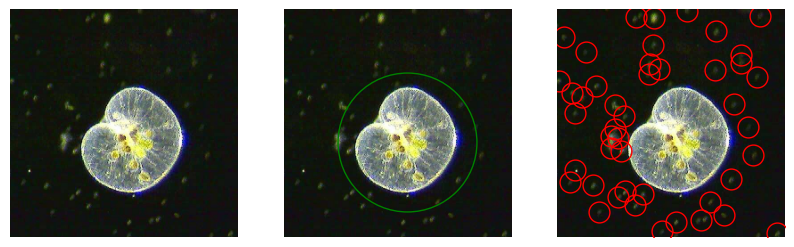

In [52]:
positions_noctiluca = detect_blobs_area(output[0, 1, :, :] > 0.5, min_area=10)
positions_dunaliella = detect_blobs_area(output[0, 2, :, :] > 0.5, min_area=10)

plt.figure(figsize=(10, 30))
plt.subplot(1, 3, 1)
plt.imshow(original_image.astype(np.uint8))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(original_image.astype(np.uint8))
[
    plt.plot(
        p[1],
        p[0],
        "o",
        ms=100,
        markerfacecolor="None",
        markeredgecolor="green",
        markeredgewidth=1,
        alpha=1,
    )
    for p in positions_noctiluca
]
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(original_image.astype(np.uint8))
[
    plt.plot(
        p[1],
        p[0],
        "o",
        ms=15,
        markerfacecolor="None",
        markeredgecolor="red",
        markeredgewidth=1,
        alpha=1,
    )
    for p in positions_dunaliella
]
plt.axis("off")
plt.show()


plt.show()